In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance


ModuleNotFoundError: No module named 'numba'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from sklearn.utils import resample
from sklearn.utils import shuffle

## Import Dataset

In [ ]:
df_yf = gd.get_yf_data(tickers= "SPY COMP AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  6 of 6 completed


In [ ]:
df = df_yf[df_yf['Ticker'] == 'ALGM']
index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

## Get Labels: Trend Scanning method

In [ ]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Get Labels: Simple moving average cross over strategy

In [ ]:
# need to cite here ...

# compute moving averages
fast_window = 20
slow_window = 50

df['fast_mavg'] = df['Adj Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = df['Adj Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df.head()

# Compute sides
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

## Raw Data 

In [ ]:
# Save the raw data
raw_data = df.copy()

# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
print(df['label'].value_counts())
print(df['side'].value_counts())

## Form Dollar Bars

In [8]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [9]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
tEvents = flt.getTEvents(close, h=dailyVolatility.mean())

# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [12]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

In [13]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()



c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


0    89
1    53
Name: bin, dtype: int64


## Results of Primary Model

In [ ]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

## Create Trade or Not Trade labels using Triple Barrier Method

In [ ]:
labels = tbar.get_bins(triple_barrier_events = events, close=close)

print(labels.bin.value_counts())

In [14]:
# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)

print(clean_labels.bin.value_counts())

0    89
1    53
Name: bin, dtype: int64


In [15]:
clean_labels

,ret,trgt,bin,side
2022-03-23,0.061462,0.018217,1,1.0
2022-03-25,-0.035641,0.036385,0,1.0
2022-03-29,0.132253,0.035012,1,-1.0
2022-03-31,0.117670,0.039976,1,-1.0
2022-04-04,0.107438,0.035391,1,-1.0
...,...,...,...,...
2023-02-17,0.036571,0.043208,0,-1.0
2023-02-21,0.058769,0.043756,0,1.0
2023-02-22,0.053671,0.044008,0,1.0
2023-02-23,-0.034399,0.043149,0,-1.0


#### Use features: volatility, serial correlation, relative strength to S&P

In [16]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(df['Adj Close'], index_SPY['Adj Close']).dropna()


In [17]:
# fractional differentiated log dollar bar prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# frac diff 1 time
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# apply cumsum filter
dfx1_close = dfx1.close.copy()
df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# fracDiff value feature
frac_diff_feat = dfx1.loc[df_tEvents]


In [18]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            .assign(side=clean_labels.side)
            .assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            #.assign(frac_diff_feat=frac_diff_feat)
            .drop_duplicates()
            .dropna())

In [19]:
Xy = (pd.merge_asof(features, clean_labels.bin, 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

In [20]:
Xy.bin.value_counts()

0    88
1    48
Name: bin, dtype: int64

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

In [22]:
RANDOM_STATE = 42

X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

              precision    recall  f1-score   support

           0       0.73      0.50      0.59        48
           1       0.31      0.55      0.40        20

    accuracy                           0.51        68
   macro avg       0.52      0.53      0.50        68
weighted avg       0.61      0.51      0.54        68

[[24 24]
 [ 9 11]]
0.5147058823529411


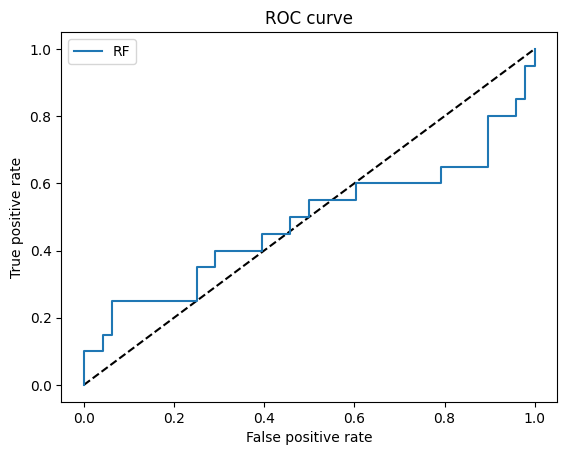

In [23]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', 
                            class_weight='balanced',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Compute the number of overlapping outcomes at each point in time.

In [24]:
import afml.sampling.concurrent as cur
import afml.sample_weights.attribution as atr
import afml.util.multiprocess as mul

# compute the number of concurrent events per bar.
numCoEvents = mul.mp_pandas_obj(cur.num_concurrent_events,('molecule', events.index),                         
                              cpus, close_series_index=close.index, label_endtime=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()

# Estimating the Average Uniqueness of a Label
out['tW'] = mul.mp_pandas_obj(cur._get_average_uniqueness,('molecule', events.index),
                            cpus,label_endtime=events['t1'],num_conc_events=numCoEvents)

# Determination of Sample Weight by Absolute Return Attribution

out['w']=mul.mp_pandas_obj(atr._apply_weight_by_return,('molecule', events.index),cpus,
                         label_endtime=events['t1'],num_conc_events=numCoEvents,close_series=close)
out['w']*=out.shape[0]/out['w'].sum()

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:31: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.iteritems():
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:113: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Spec

#### Bagging Classifier of Decision Tree

In [25]:
import afml.ensemble.sb_bagging as bag

In [26]:
# rf = RandomForestClassifier(
# n_estimators=1,
# max_depth=5,
# random_state=42,
# class_weight='balanced',
# min_weight_fraction_leaf=0.05
# )

# clf = SequentiallyBootstrappedBaggingClassifier(
# samples_info_sets=samples_info_sets,
# price_bars=price_bars_trim,
# base_estimator=rf,
# random_state=42,
# max_features=4,
# max_samples=avg_uniqueness.tW.mean(),
# n_estimators=100,
# bootstrap_features=True,
# n_jobs=20,
# verbose=5
# )

In [29]:
t1_copy = t1.copy().rename('t1')

In [30]:
bag_clf = bag.SequentiallyBootstrappedBaggingClassifier(
            base_estimator=rf,
            samples_info_sets=t1_copy,
            price_bars= pd.DataFrame(close),
            random_state=RANDOM_STATE,
            oob_score=True,
            max_samples=out.tW.mean(),
            verbose=5)

bag_clf.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'index'